In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0


In [2]:
results_folder = '/lustre/scratch117/cellgen/team205/rl20/kidney_final/Visium'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [15]:
### object with raw counts ### not sure
scRNA_path = '/lustre/scratch117/cellgen/team205/rl20/kidney_final/allCells_concatenate_anno_ENSG.h5ad'
adata_ref = sc.read(scRNA_path)

In [16]:
celltype_key = 'annotation'
adata_ref.obs[celltype_key].value_counts()

CD8+T_EM                    19247
CD8+T_EFF.2                 15014
CD8+T_preEX-CXCR4           13925
CD4+T_Naïve/CM              10360
CD8+T_EMRA                  10156
                            ...  
Type B intercalated cell       52
Pelvic urothelial cell         48
Lymphatic_EC                   42
Cycling_EC                     32
CDH19+ Fibro                   23
Name: annotation, Length: 107, dtype: int64

In [17]:
# Remove 'unclassified' cells
adata_ref = adata_ref[~adata_ref.obs[celltype_key].isin(['Unknown', 'Low quality',
                                                        'CD4+T_Naïve/CM-patient-specific.1', 'CD4+T_Naïve/CM-patient-specific.2'])]

In [18]:
adata_ref.var

,name,ENSEMBL
FAM138A,FAM138A,ENSG00000237613
OR4F5,OR4F5,ENSG00000186092
AP006222.2,AP006222.2,ENSG00000286448
OR4F29,OR4F29,ENSG00000284733
OR4F16,OR4F16,ENSG00000284662
...,...,...
AC023491.2,AC023491.2,ENSG00000278633
AC233755.2,AC233755.2,ENSG00000277856
AC233755.1,AC233755.1,ENSG00000275063
AC240274.1,AC240274.1,ENSG00000271254


In [19]:
# Use ENSEMBL as gene IDs to make sure IDs are unique and correctly matched
adata_ref.var.index = adata_ref.var['ENSEMBL'].copy()
adata_ref.var_names = adata_ref.var['ENSEMBL'].copy()
adata_ref.var.index.name = None
adata_ref.var

,name,ENSEMBL
ENSG00000237613,FAM138A,ENSG00000237613
ENSG00000186092,OR4F5,ENSG00000186092
ENSG00000286448,AP006222.2,ENSG00000286448
ENSG00000284733,OR4F29,ENSG00000284733
ENSG00000284662,OR4F16,ENSG00000284662
...,...,...
ENSG00000278633,AC023491.2,ENSG00000278633
ENSG00000277856,AC233755.2,ENSG00000277856
ENSG00000275063,AC233755.1,ENSG00000275063
ENSG00000271254,AC240274.1,ENSG00000271254


## Estimation of reference cell type signatures (NB regression)

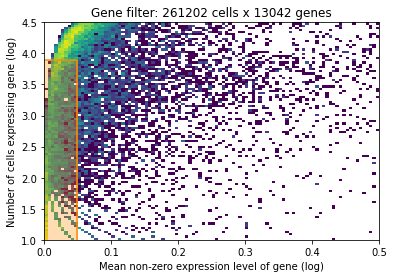

In [20]:
# before we estimate the reference cell type signature we recommend to perform very permissive genes selection
# in this 2D histogram orange rectangle lays over excluded genes.
# In this case, the downloaded dataset was already filtered using this method,
# hence no density under the orange rectangle

from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [22]:
# prepare anndata for the regression model
scvi.data.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='patient',
                        # cell type, covariate used for constructing signatures
                        labels_key=celltype_key
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        #categorical_covariate_keys=['patient']
                       )
scvi.data.view_anndata_setup(adata_ref)

INFO     Using batches from adata.obs["patient"]                                             
INFO     Using labels from adata.obs["annotation"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/rl20/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 261202 cells, 13042 vars, 12      
         batches, 103 labels, and 0 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


Anndata setup with scvi-tools version 0.14.6.

              Data Summary               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃             Data             ┃ Count  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│            Cells             │ 261202 │
│             Vars             │ 13042  │
│            Labels            │  103   │
│           Batches            │   12   │
│           Proteins           │   0    │
│ Extra Categorical Covariates │   0    │
│ Extra Continuous Covariates  │   0    │
└──────────────────────────────┴────────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                              Label Categories                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['annotation'] │         ACKR+_EC         │          0          │
│                         │    Activated KRT+ NK     │          1          │
│                         │       Activated NK       │          2          │
│                         │     Activated_B-AREG     │          3          │
│                         │     Activated_B-RHOB     │          4          │
│                         │         CCL5+_EC         │          5          │
│                         │            CD            │          6          │
│                         │      CD4+T_Act-CCL5      │          7          │
│                         │     CD4+T_Act-CH25H      │          8          │
│                         │     CD4+T_Act-CXCR4      │          9          │
│                         │     CD4+T_Act-NR4A1      │         10          │
│                         │         CD4+T_EM         │         11          │
│                         │    CD4+T_INF-response    │         12          │
│                         │      CD4+T_Naïve/CM      │         13          │
│                         │         CD4+Treg         │         14          │
│                         │     CD8+T_Act-XCL1/2     │         15          │
│                         │    CD8+T_Cycling-G1/S    │         16          │
│                         │    CD8+T_Cycling-G2/M    │         17          │
│                         │       CD8+T_EFF.1        │         18          │
│                         │       CD8+T_EFF.2        │         19          │
│                         │         CD8+T_EM         │         20          │
│                         │        CD8+T_EMRA        │         21          │
│                         │     CD8+T_EX-CCL4L2      │         22          │
│                         │      CD8+T_EX-IL10       │         23          │
│                         │      CD8+T_Naïve/CM      │         24          │
│                         │     CD8+T_RM-CXCL13      │         25          │
│                         │    CD8+T_preEX-CXCR4     │         26          │
│                         │     CD8+T_preEX-PMCH     │         27          │
│                         │    CD principal cell     │         28          │
│                         │       CDH19+ Fibro       │         29          │
│                         │       CNN1+ Fibro        │         30          │
│                         │        CRHBP+_EC         │         31          │
│                         │        CRYAB+ Epi        │         32          │
│                         │       CYGB+ Fibro        │         33          │
│                         │     Classical Mono.1     │         34          │
│                         │     Classical Mono.2     │         35          │
│                         │     Classical Mono.3     │         36          │
│                         │     Classical Mono.4     │         37          │
│                         │      Collagen Fibro      │         38          │
│                         │       Collagen_EC        │         39          │
│                         │  Connecting tubule cell  │         40          │
│                         │         Cycling          │         41          │
│                         │        Cycling_EC        │         42          │
│                         │         DCT cell         │         43          │
│                         │       DNASE1L3+_EC       │         44          │
│                         │           EMT            │         45          │
│                         │        FABP4+_EC         │         46          │
│                         │         FN1+ TAM         │         47        

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient'] │ PD43824_incDoublets.h5ad │          0          │
│                      │ PD43948_incDoublets.h5ad │          1          │
│                      │ PD44714_incDoublets.h5ad │          2          │
│                      │ PD44966_incDoublets.h5ad │          3          │
│                      │ PD44967_incDoublets.h5ad │          4          │
│                      │ PD45814_incDoublets.h5ad │          5          │
│                      │ PD45815_incDoublets.h5ad │          6          │
│                      │ PD45816_incDoublets.h5ad │          7          │
│                      │ PD47171_incDoublets.h5ad │          8          │
│                      │ PD47172_incDoublets.h5ad │          9          │
│                      │ PD47465_incDoublets.h5ad │         10          │
│                      │ PD47512_incDoublets.h5ad │         11          │
└──────────────────────┴──────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/rl20/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/120:   0%|                                      | 0/120 [00:00<?, ?it/s]

/lustre/scratch117/cellgen/team205/rl20/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /nfs/users/nfs_r/rl20/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/cuda/jit_utils.cpp:860.)


Epoch 120/120: 100%|█| 120/120 [53:19<00:00, 26.67s/it, v_num=1, elbo_train=1.17


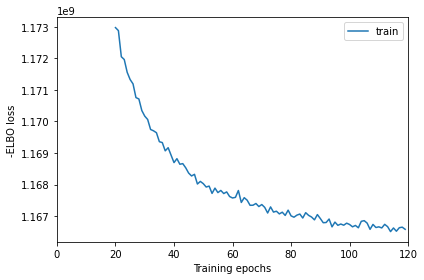

In [23]:
# create and train the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=120, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [24]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████| 999/999 [00:12<00:00, 81.42it/s]


'/lustre/scratch117/cellgen/team205/rl20/kidney_final/Visium/test5/reference_signatures/sc.h5ad'

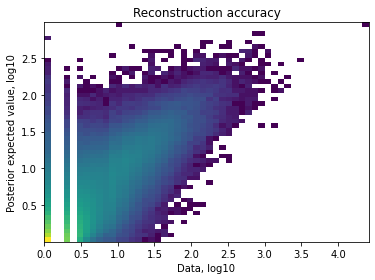

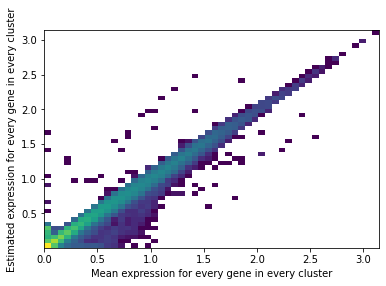

In [25]:
mod.plot_QC()

In [26]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

# save inf_aver
inf_aver.to_csv(f"{ref_run_name}/inf_aver.csv")